# Benchmark: PXD024043 - Proteins

This notebook contains code to benchmark the model on the [PXD024043 dataset](https://www.ebi.ac.uk/pride/archive/projects/PXD024043) - cell cycle proteomes. 
Four cell populations enriched in different cell cycle stages were produced from HeLa cells by drug treatment.
Here, we'll use the protein dataset. Download the zip-file, "DIANN1.8_SingleCells_CellCycle.zip" and locate the file, "20210919_DIANN_SingleCellOutput.pg_matrix.tsv".

Let's start with the imports.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch
from scipy.stats import spearmanr, pearsonr

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import manns_lab_support as sup
from scp.models import PROTVI
import scp.plots as pl
import scp.utils as utils

import scvi

np.random.seed(42)
scvi.settings.seed = 42

Global seed set to 42


Let's define the path to the data.

In [2]:
DATA_PATH = "../data/PXD024043/20210919_DIANN_SingleCellOutput.pg_matrix.tsv"

## Data loading

Let's load the data

In [3]:
data = pd.read_csv(DATA_PATH, sep="\t")

In [4]:
var_cols = [c for c in data.columns if "D:\\" not in c]
vars = data[var_cols]

data.drop(var_cols, axis=1, inplace=True)

data = data.T
data = np.log(data + 1)

obs_names = [filename.split("\\")[-1] for filename in data.index.copy()]
data.index = obs_names

In [5]:
obs_new = [obs.replace("-", "_").replace("SA_ADB", "SA-ADB") for obs in obs_names]
annotations = [obs.split("_") for obs in obs_new]

dates = [obs[0] for obs in annotations]
unknown1 = [obs[3] for obs in annotations]
n_cells = [obs[4] for obs in annotations]
species = [obs[5] for obs in annotations]
unknown2 = [obs[6] for obs in annotations]
unknown3 = [obs[7] for obs in annotations]
unknown4 = [obs[8] for obs in annotations]
position = [obs[9] for obs in annotations]
replicate = [obs[10] for obs in annotations]
file_index = [obs[11][:-2] for obs in annotations]

condition = [
    "G1" if "G1" in unk2
    else "G1-S" if "TB" == unk2
    else "G2" if "G2" == unk2
    else "G1-M" if "NB" == unk2
    else "UB_Passage01" if ("UB" == unk2) and ("20201010" == date)
    else "UB_Passage02_Plate01" if ("UB" == unk2) and (int(file_index) < 5050)
    else "UB_Passage02_Plate02"
    for unk2, file_index, date in zip(unknown2, file_index, dates)
]

cell_cycle_stage = [
    "G1" if "G1" == name
    else "G1-S" if "TB" == name
    else "G2" if "G2" == name
    else "G2-M" if "NB" == name
    else "other"
    for name in unknown2
]

coarse_condition = ["UB" if "UB" in c else "G" for c in condition]

In [6]:
obs = pd.DataFrame(
    {
        "date": dates,
        "unknown1": unknown1,
        "n_cells": n_cells,
        "species": species,
        "unknown2": unknown2,
        "unknown3": unknown3,
        "unknown4": unknown4,
        "position": position,
        "replicate": replicate,
        "file_index": file_index,
        "condition": condition,
        "coarse_condition": coarse_condition,
        "cell_cycle_stage": cell_cycle_stage,
    },

    index=obs_names,
)

adata = sc.AnnData(X=data, var=vars, obs=obs)

adata.X[adata.X == 0] = np.NaN
adata.layers["raw"] = adata.X.copy()

In [7]:
#utils.filter_by_detection_proportion(adata, 0.1)

In [8]:
adata

AnnData object with n_obs × n_vars = 434 × 2501
    obs: 'date', 'unknown1', 'n_cells', 'species', 'unknown2', 'unknown3', 'unknown4', 'position', 'replicate', 'file_index', 'condition', 'coarse_condition', 'cell_cycle_stage'
    var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description'
    layers: 'raw'

## Data Exploration

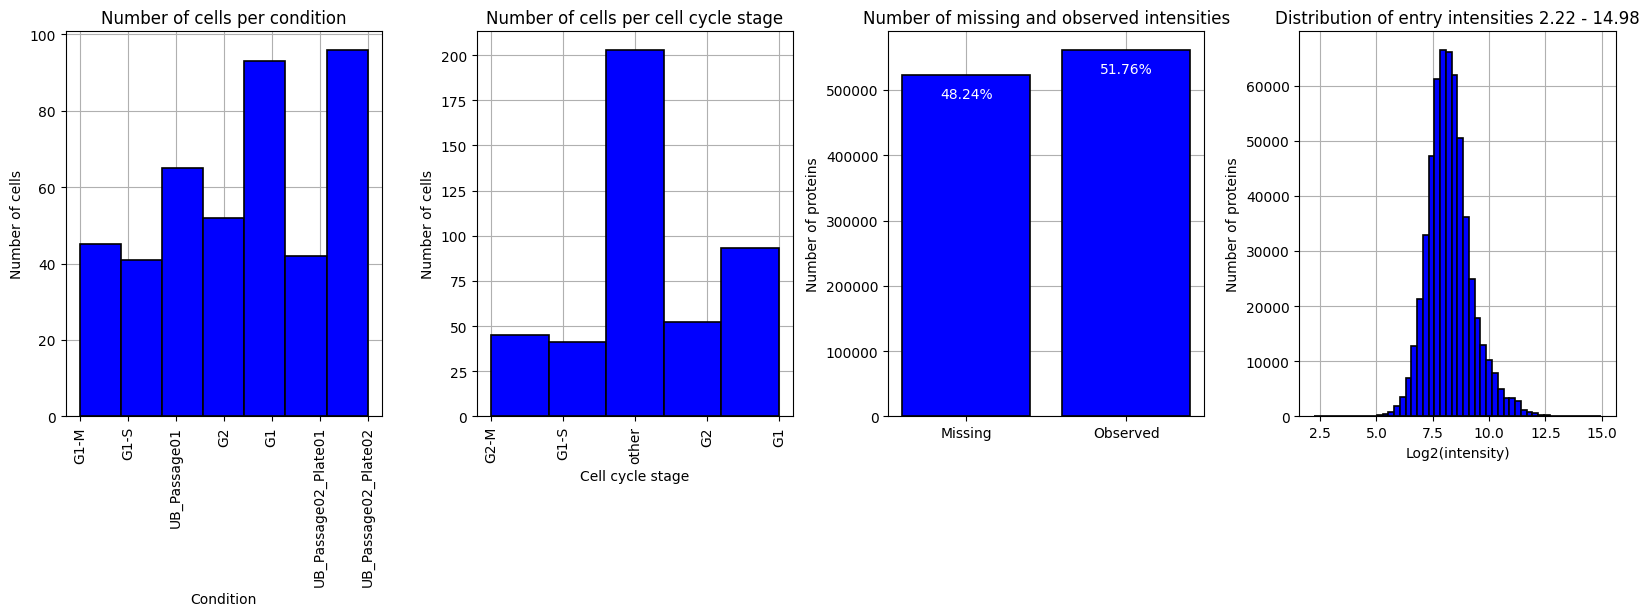

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.subplots_adjust(wspace=0.3)

x = adata.layers["raw"]

ax = axes[0]
ax.hist(adata.obs["condition"], bins=len(adata.obs["condition"].unique()), color="blue", edgecolor="black", linewidth=1.2)
ax.set_title("Number of cells per condition")
ax.set_xlabel("Condition")
ax.set_ylabel("Number of cells")
ax.grid(True)
ax.set_axisbelow(True)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax = axes[1]
ax.hist(adata.obs["cell_cycle_stage"], bins=len(adata.obs["cell_cycle_stage"].unique()), color="blue", edgecolor="black", linewidth=1.2)
ax.set_title("Number of cells per cell cycle stage")
ax.set_xlabel("Cell cycle stage")
ax.set_ylabel("Number of cells")
ax.grid(True)
ax.set_axisbelow(True)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax = axes[2]
n_miss = np.isnan(x).sum()
n_obs = (~np.isnan(x)).sum()
n_total = n_miss + n_obs
ax.bar(["Missing", "Observed"], [n_miss, n_obs], color="blue", edgecolor="black", linewidth=1.2)
ax.set_ylabel("Number of proteins")
ax.set_title("Number of missing and observed intensities")
ax.grid(True)
ax.set_axisbelow(True)

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height - 40_000, f"{height / n_total* 100:.2f}%", ha="center", va="bottom", color="white")

# plot intensity distribution
ax = axes[3]
x = x[~np.isnan(x)].flatten()

ax.hist(x, bins=50, color="blue", edgecolor="black", linewidth=1.2)
ax.set_xlabel("Log2(intensity)")
ax.set_ylabel("Number of proteins")
ax.set_title(f"Distribution of entry intensities {np.min(x):.2f} - {np.max(x):.2f}")
ax.grid(True)
ax.set_axisbelow(True)

Let's see if we can decide which annotation is the batch effect.

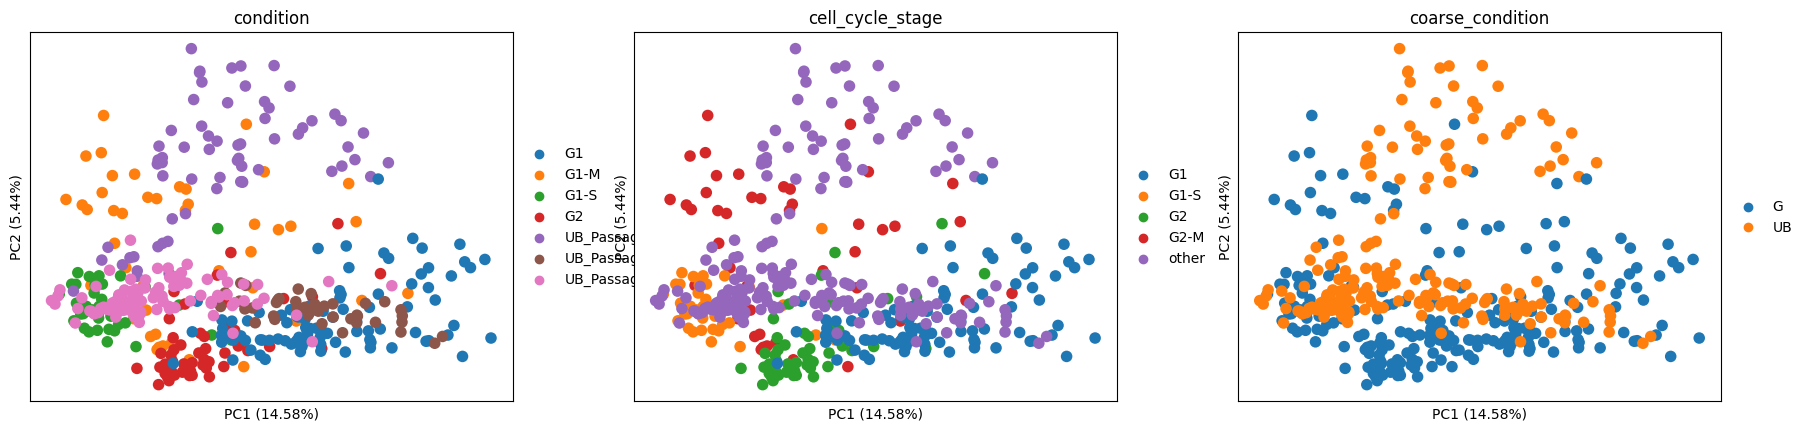

In [11]:
adata.X = utils.impute_downshifted_normal_sample(adata.layers["raw"])

sc.tl.pca(adata, n_comps=16)

sc.pl.pca(
    adata,
    annotate_var_explained=True,
    color=["condition", "cell_cycle_stage", "coarse_condition"], 
    components=["1,2"],
)

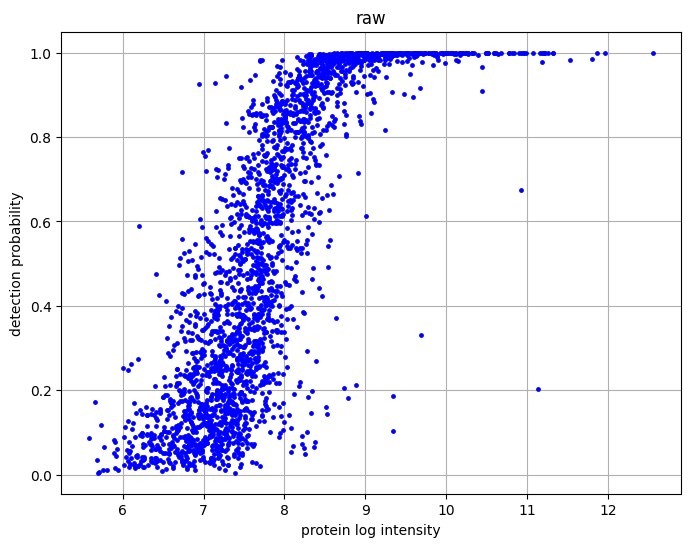

In [12]:
pl.scatter_protein_detection_probability_and_intensity(adata.layers["raw"], title="raw")

## PROTVI

### Training

Let's now train the model.

In [13]:
adata.X = adata.layers["raw"].copy()
adata.X[np.isnan(adata.X)] = 0

In [14]:
PROTVI.setup_anndata(adata, batch_key="coarse_condition")

model = PROTVI(adata, log_variational=False)
#model.view_anndata_setup()

Let's train the model.

In [15]:
model.train(max_epochs=800)#, plan_kwargs={"min_kl_weight": 6, "max_kl_weight": 6})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 800/800: 100%|██████████| 800/800 [01:21<00:00, 11.82it/s, v_num=1, train_loss_step=2.93e+3, train_loss_epoch=2.43e+3]

`Trainer.fit` stopped: `max_epochs=800` reached.


Epoch 800/800: 100%|██████████| 800/800 [01:21<00:00,  9.77it/s, v_num=1, train_loss_step=2.93e+3, train_loss_epoch=2.43e+3]


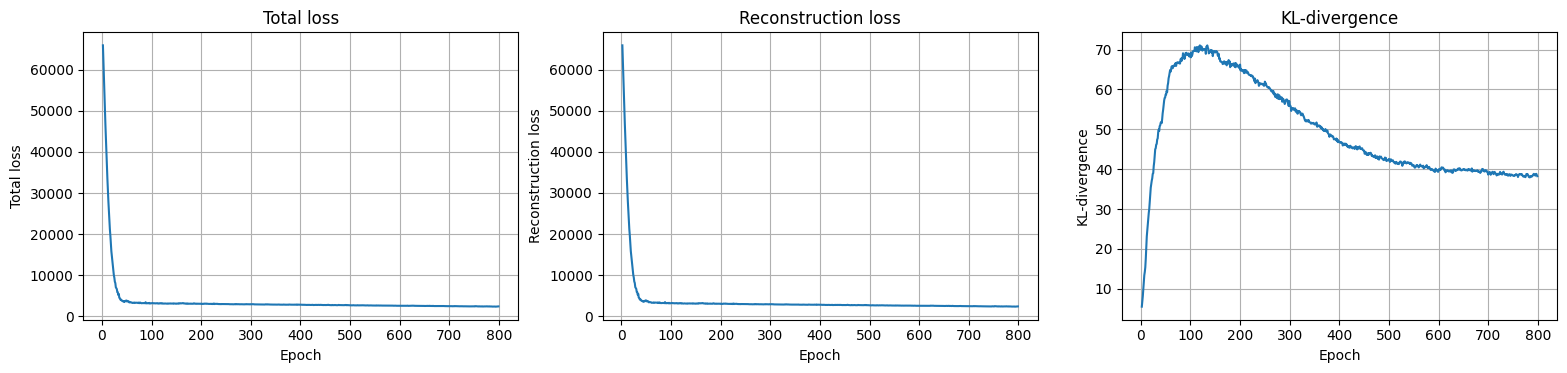

In [16]:
pl.plot_loss(model.history, n_skip=2)

### Evaluation on training set

In [17]:
x_est, p_est = model.impute()

x_data = adata.layers["raw"]

x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_data)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_data)] = np.nan

Let's look at the predicted detection probability for each protein, and compare it to the observed missingness.

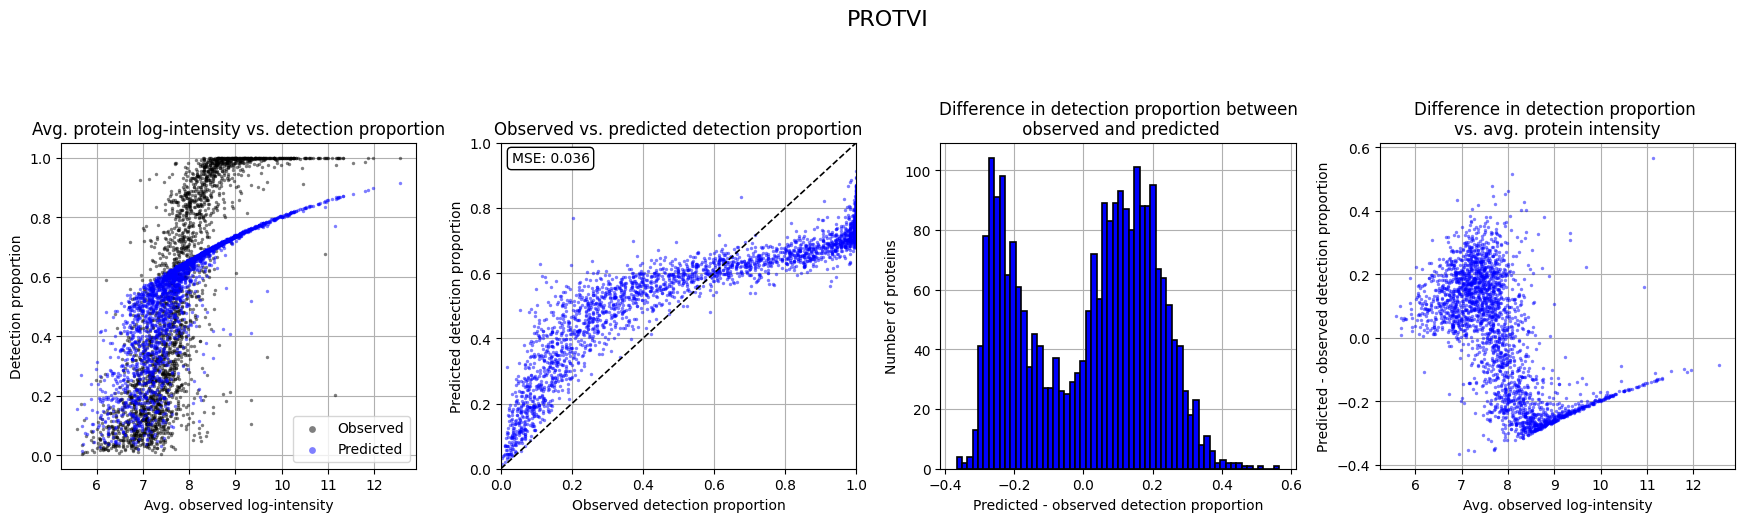

In [18]:
pl.plot_protein_detection_probability_panel(x_data, p_est)

Let's now compare the protein intensities predicted by the model and the intensities in dataset.

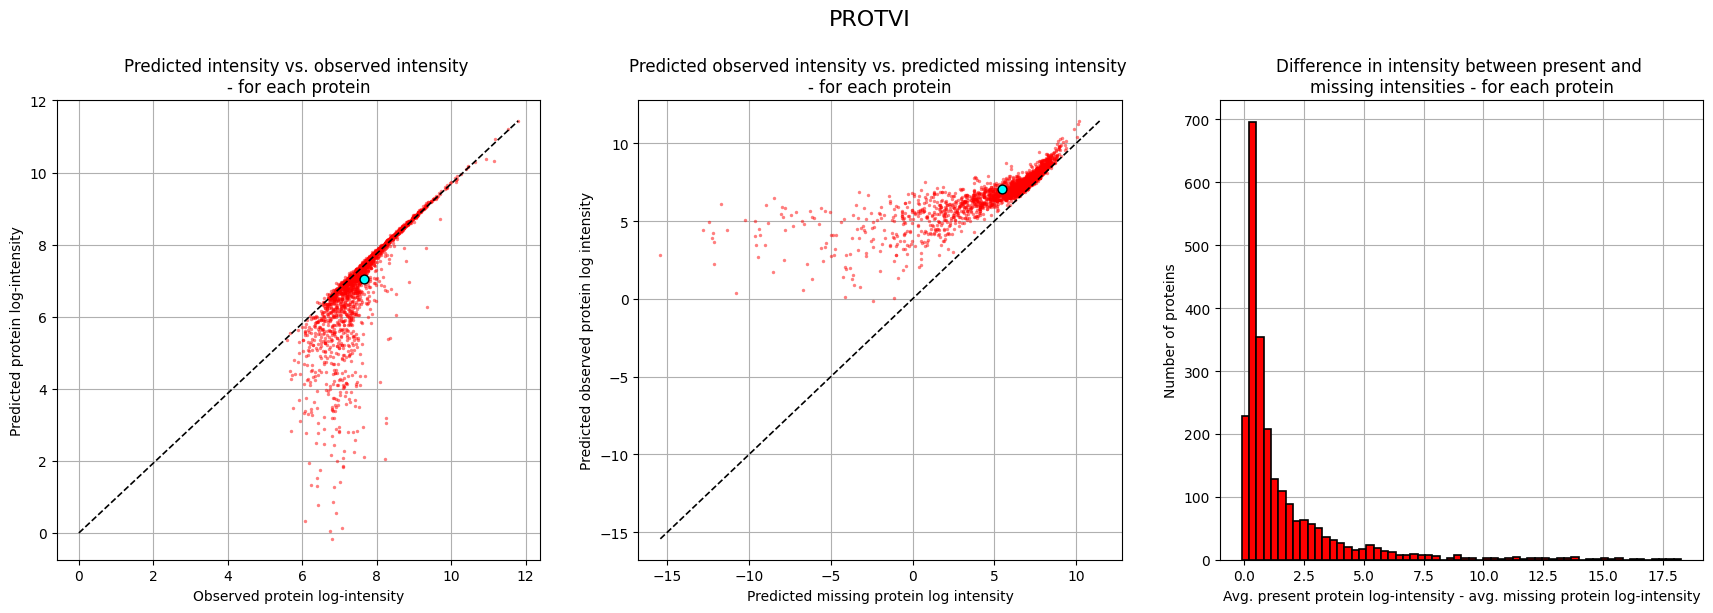

In [19]:
pl.plot_protein_intensity_panel(x_data, x_est)

Let's look at the latent space.

In [20]:
latent = model.get_latent_representation()
adata.obsm["latent"] = latent

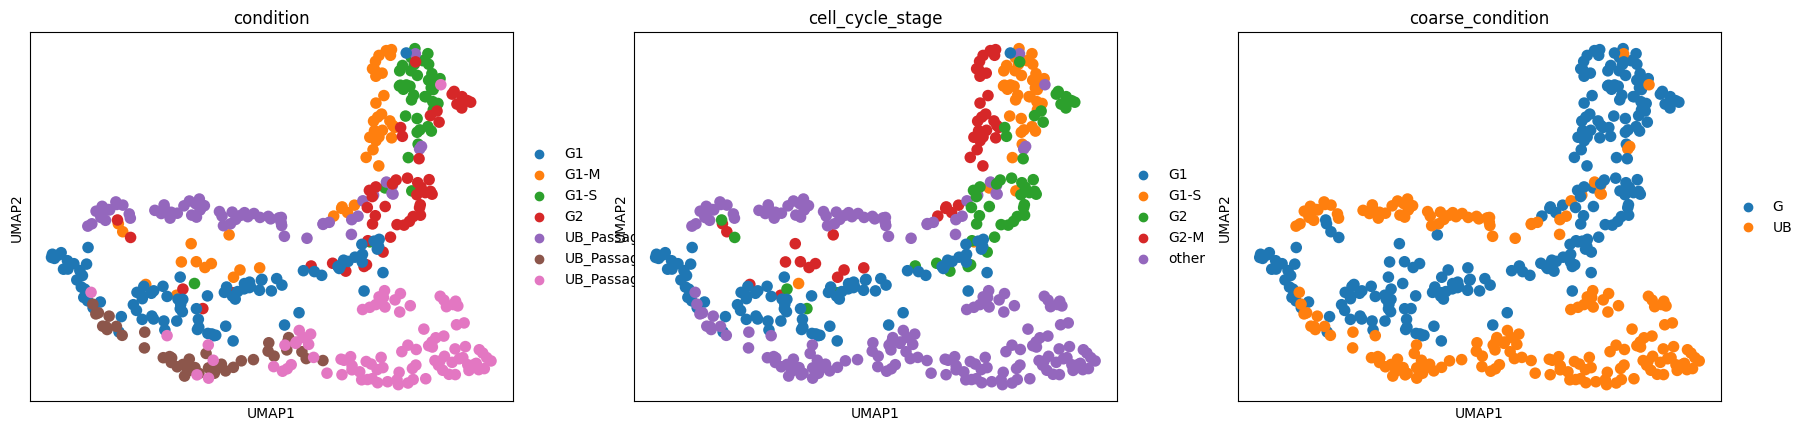

In [21]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)

sc.pl.umap(
    adata, 
    color=["condition", "cell_cycle_stage", "coarse_condition"], 
    vmin="p01", vmax="p99",
)

Let's see how much of the variance can be explained by PCA.

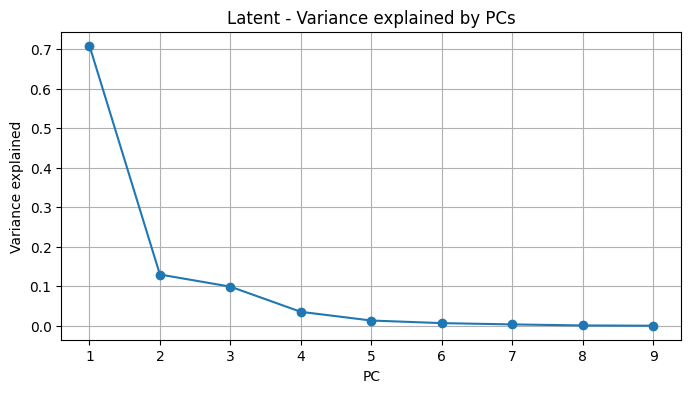

In [22]:
latent_pcs, pcs, var_ratio, var = sc.tl.pca(adata.obsm["latent"], return_info=True)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(np.arange(1, latent_pcs.shape[1]+1), var_ratio, marker="o")
ax.set_xticks(np.arange(1, latent_pcs.shape[1]+1))
ax.set_xlabel("PC")
ax.set_ylabel("Variance explained")
ax.set_title("Latent - Variance explained by PCs")
ax.grid(True)
ax.set_axisbelow(True)

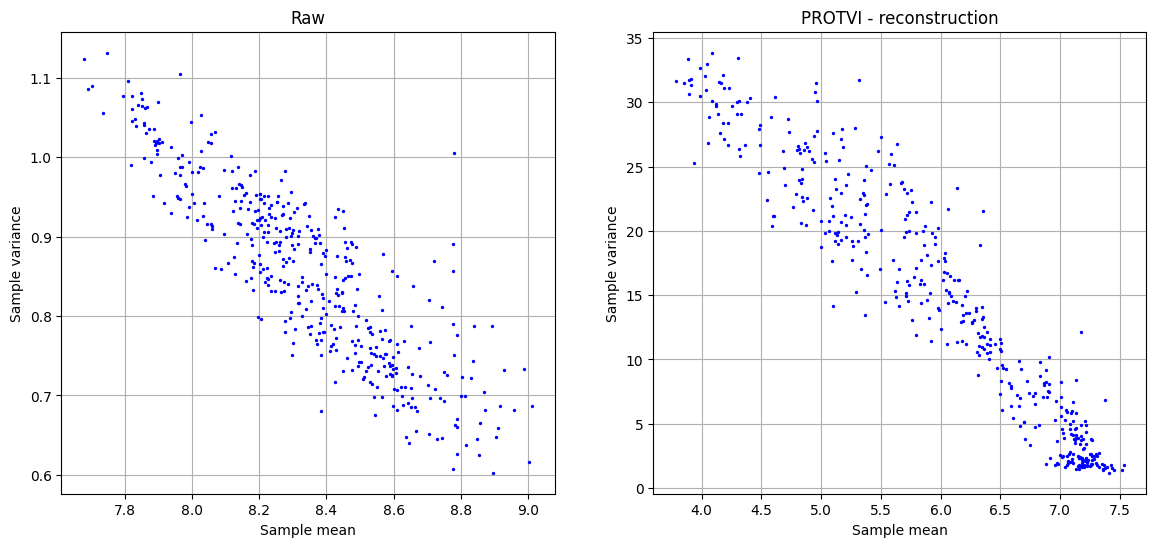

In [23]:
fig, axes = plt.subplots(figsize=(14, 6), ncols=2)
pl.scatter_sample_mean_and_variance(adata.layers["raw"], title="Raw", ax=axes[0])
pl.scatter_sample_mean_and_variance(x_est, "PROTVI - reconstruction", ax=axes[1])

Let's do a mean-cv plot for UB cells.

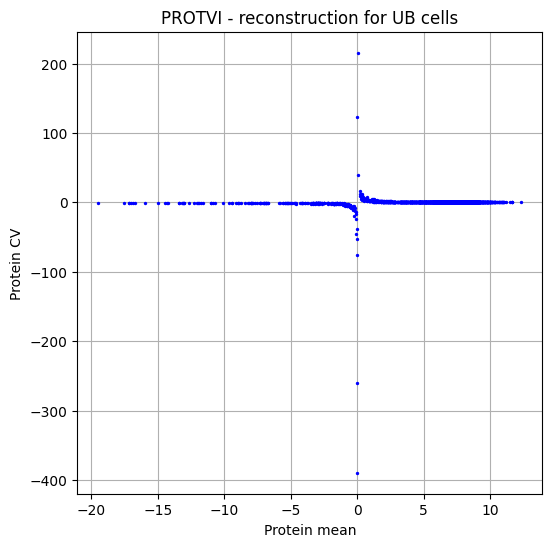

In [52]:
mask = adata.obs["condition"].str.startswith("UB").values
x_est_sub = x_est[mask,:]

pl.scatter_protein_mean_and_cv(x_est_sub, title="PROTVI - reconstruction for UB cells")

## protDP

Let's also train [protDP](https://mengbo-li.github.io/protDP/index.html) for later comparison.

### Training

First, we'll fit protDP to the data.

In [ ]:
%%capture
import anndata2ri
anndata2ri.activate()

import rpy2.robjects as robjects
%load_ext rpy2.ipython

In [ ]:
r_adata = utils.prepare_anndata_for_R(adata)

In [ ]:
%%R -i r_adata
library(protDP)

X <- assay(r_adata, "raw")
dpcfit <- dpc(X)

In [ ]:
protdp_result = robjects.r("dpcfit")

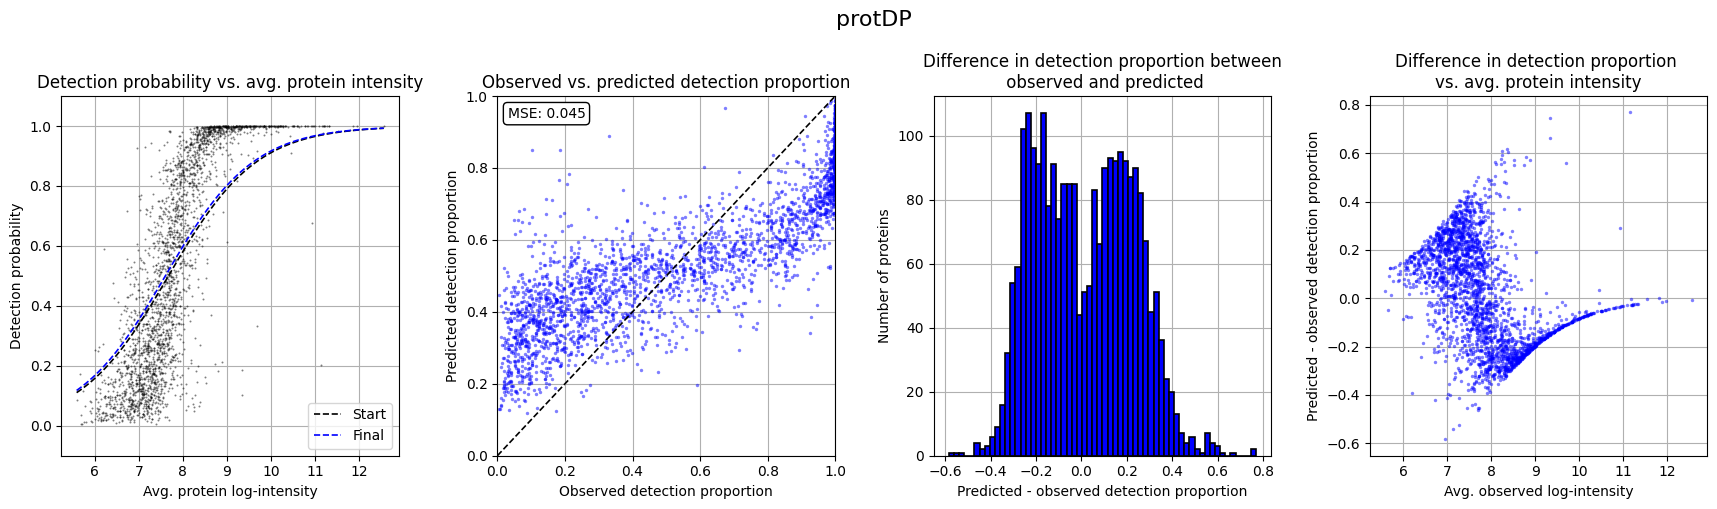

In [ ]:
pl.plot_protein_detection_probability_panel_protDP(x_data, protdp_result)

### protDP vs PROTVI

Let's compare the results of the two methods:

/tmp/ipykernel_189921/1935104467.py:8: RuntimeWarning: Mean of empty slice
  x_est_miss_protein = np.nanmean(x_est_miss, axis=0)


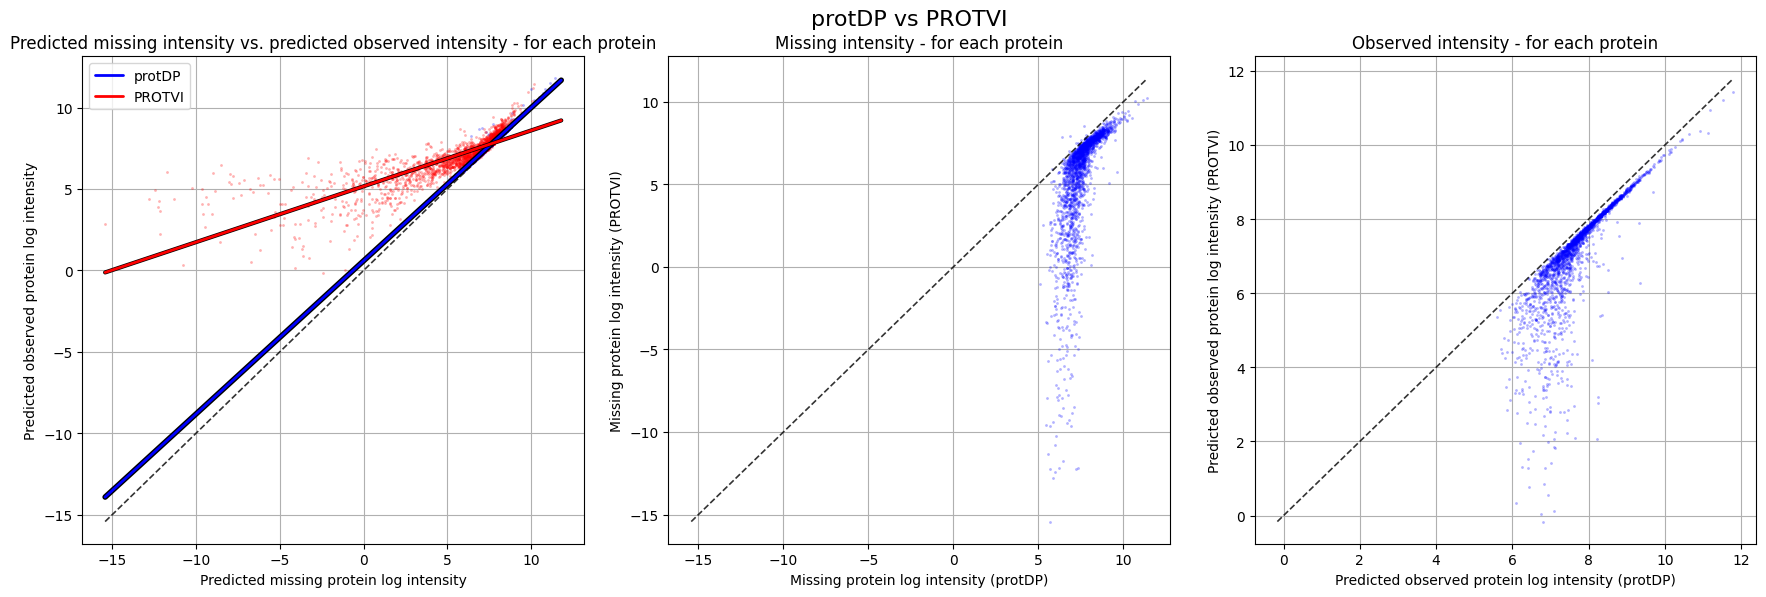

In [ ]:
x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_data)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_data)] = np.nan

x_est_obs_protein = np.nanmean(x_est_obs, axis=0)
x_est_miss_protein = np.nanmean(x_est_miss, axis=0)

pl.plot_model_intensity_comparison(
    x_data, 
    protdp_result["mu_obs"], 
    protdp_result["mu_mis"],
    x_est_obs_protein, 
    x_est_miss_protein,
    "protDP",
    "PROTVI"
)

## Other Imputation Methods

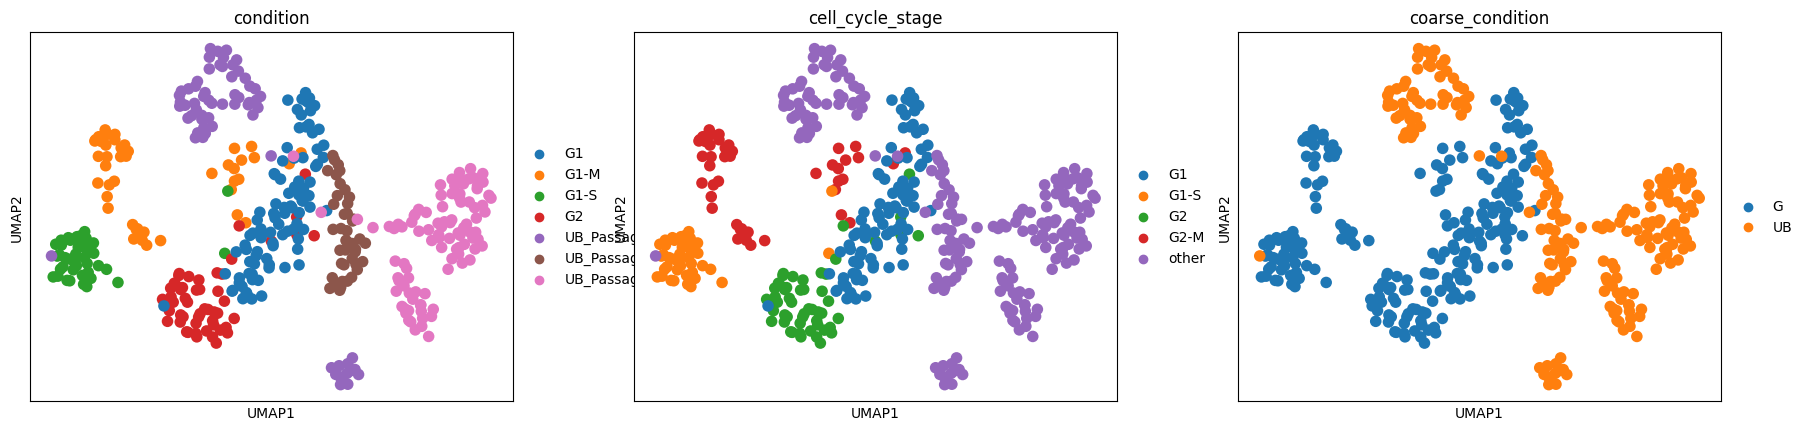

In [ ]:
adata.X = utils.impute_downshifted_normal_sample(adata.layers["raw"])

sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(
    adata, 
    color=["condition", "cell_cycle_stage", "coarse_condition"], 
)